In [4]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [5]:
six.moves.reload_module(dfm)

INFO:DFlowModel:DelwaqScalarBC instantiated.


<module 'stompy.model.delft.dflow_model' from '/home/rusty/src/stompy/stompy/model/delft/dflow_model.py'>

In [6]:
%matplotlib notebook

In [7]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [8]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')

nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [235]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time'))                

In [226]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    # QCM and BML data at NCK differ by about 10.406.
    # This is probably atmospheric pressure? There is still some variability, though
    # some of that could be due to low-pass filtering.
    observed= observed - 10.406  

In [227]:
model=pesca_base.PescaButano.load('run_salt_20160520-v66')

In [230]:
bcs=model.load_bcs()
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [195]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00


<IPython.core.display.Javascript object>


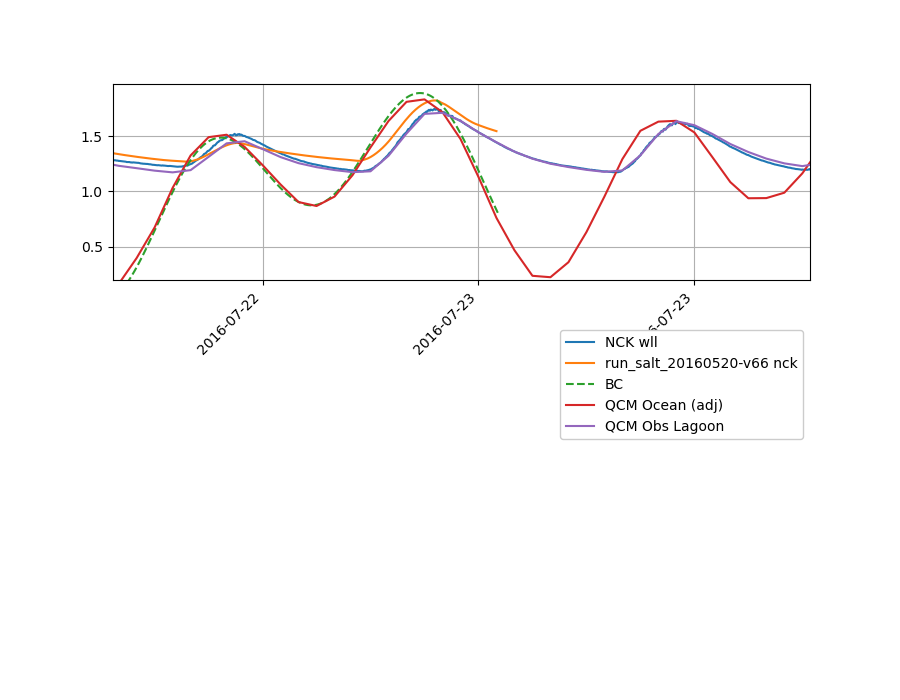

(16991.958333333332, 17005.541666666668, 0.0, 2.0)

In [238]:
import six
six.moves.reload_module(dc)

sources=[observed]

#sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
#sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

if 1: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207,0,2])

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[-1].set_linestyle('--')

if 1: # Add in QCM time series
    ax.plot(qcm.time,qcm.z_ocean,label='QCM Ocean (adj)')
    #ax.plot(qcm.time,qcm.z_ocean_orig,label='QCM Ocean (orig)')
    ax.plot(qcm.time,qcm['Observed Lagoon Level (feet NAVD88)']*0.3048,
            label='QCM Obs Lagoon')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)
ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))

<IPython.core.display.Javascript object>


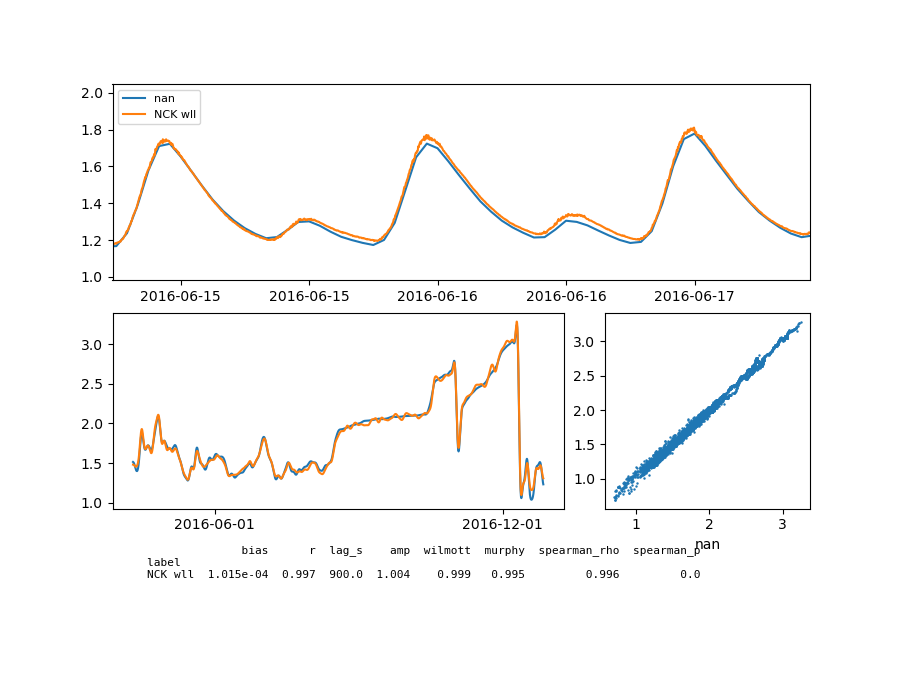

/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<IPython.core.display.Javascript object>


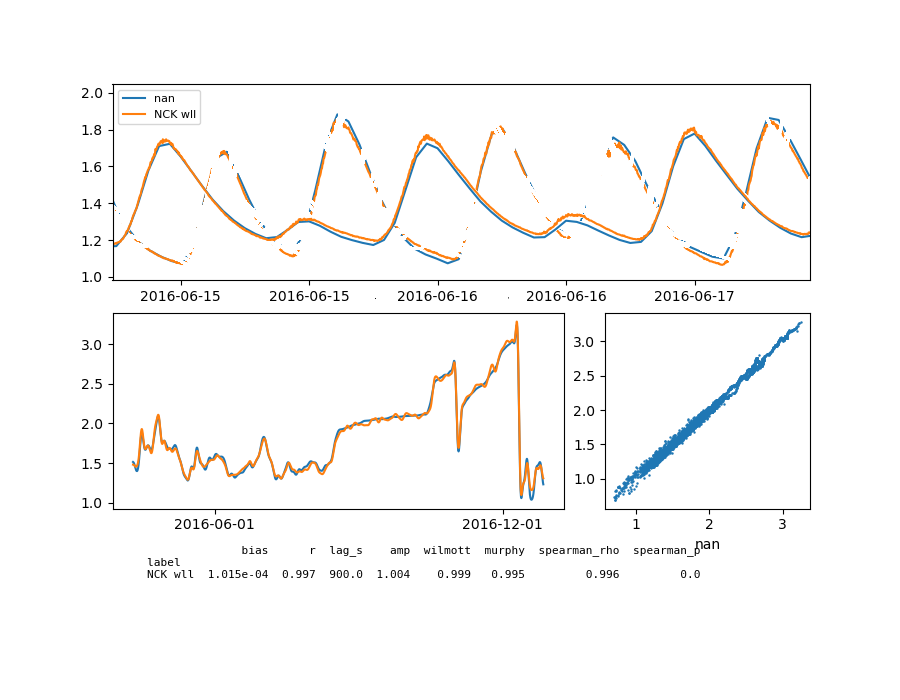

In [225]:
# Compare observed lagoon level from QCM and BML
qcm['z_lagoon']=qcm['Observed Lagoon Level (feet NAVD88)']*0.3048
ds_qcm_lagoon=xr.Dataset.from_dataframe(qcm.set_index('time'))['z_lagoon']

#combined=dc.combine_sources( [ds_qcm_lagoon,observed])

dc.calibration_figure_3panel([ds_qcm_lagoon,observed-10.406],trim_time=True,offset_source=None)

In [ ]:
fig.savefig('manytides.png',dpi=200)

Salinity Comparisons
--

In [197]:
his_ds.close()

In [198]:
his_ds=xr.open_dataset(model.his_output())

In [199]:
nck_stn=np.nonzero( his_ds.station_name.values==b'nck' )[0][0]
nck_stn

7

In [200]:
model_nck_salt=his_ds.isel(stations=nck_stn).salinity
# model_nck_salt

In [201]:
bml_nck_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_sfc_mcat_concatenated.csv")

for df in [bml_nck_sfc_mcat,
           bml_nck_btm_mcat,
           bml_pc3_sfc_sond,
           bml_pc3_btm_sond,
           bml_bc1_btm_sond,
           bml_bc1_sfc_sond,
           bml_bc3_btm_mcat,
           bml_bc3_sfc_mcat,
           bml_ch2_btm_mcat,
           bml_ch2_sfc_mcat,
]:
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    df.set_index('time',inplace=True)

In [244]:
def surface(da):
    # assume data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)

    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.choose(surf_idxs,scal.T)

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    bed_idxs=np.argmax(valid,axis=1)
    return np.choose(bed_idxs,scal.T) 
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    colors=['tab:blue','tab:orange']
    def __init__(self,ds,his_name,bml_sfc,bml_btm):
        stn=np.nonzero( ds.station_name.values==his_name )[0][0]
        stn_da=ds['salinity'].isel(stations=stn)
        
        # Pick out top/bottom finite values.
        scal=stn_da.values

        valid=np.isfinite(scal) # time,layer
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        for col,lay in zip(self.colors,self.layers):
            if lay=='surface':
                surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                lay_scal=np.choose(surf_idxs,scal.T)
                z_label="Surface"
            elif lay=='bottom':
                bed_idxs=np.argmax(valid,axis=1)
                lay_scal=np.choose(bed_idxs,scal.T) 
                z_label="Bottom"
            else:
                lay_scal=scal[:,lay]
                z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                z_label=f"z={z:.2f} m"
            ax.plot(stn_da.time, lay_scal,
                    label=f"Model {z_label}", color=col, ls="--")

        ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                color=self.colors[0],label="BML surface")
        ax.plot(bml_btm.index.values, bml_btm.salinity, 
                color=self.colors[1],label="BML bottom")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        ax.axis(xmin=model_nck_salt.time.values[0],
                 xmax=model_nck_salt.time.values[-1])
        fig.subplots_adjust(right=0.73)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        ax.axis( xmin=ds.time.values[0], xmax=ds.time.values[-1])
        name=his_name.decode()
        ax.text(0.03,0.98,name,transform=ax.transAxes,va='top')
        

<IPython.core.display.Javascript object>


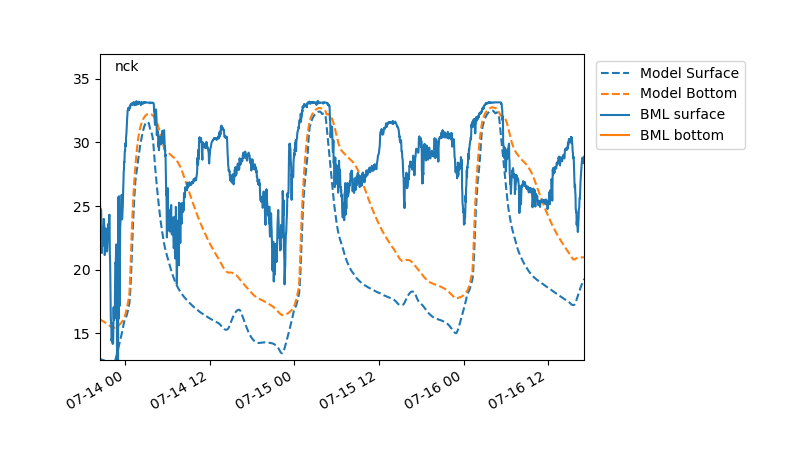

In [203]:
FigSalt(his_ds,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat)

<IPython.core.display.Javascript object>


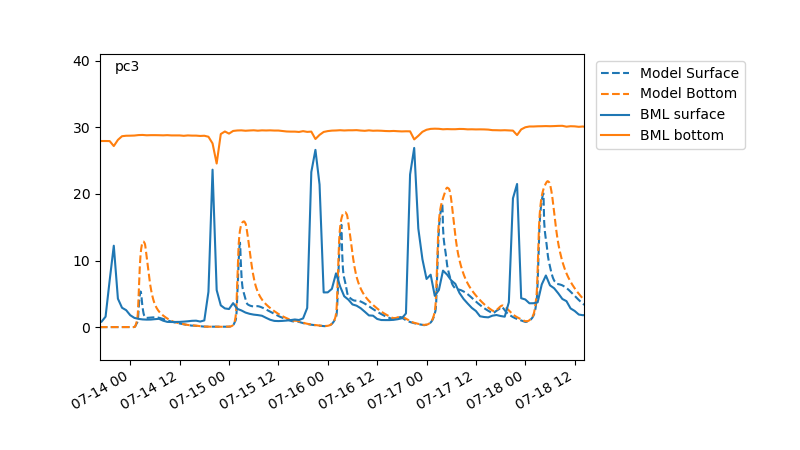

In [204]:
FigSalt(his_ds,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond)

<IPython.core.display.Javascript object>


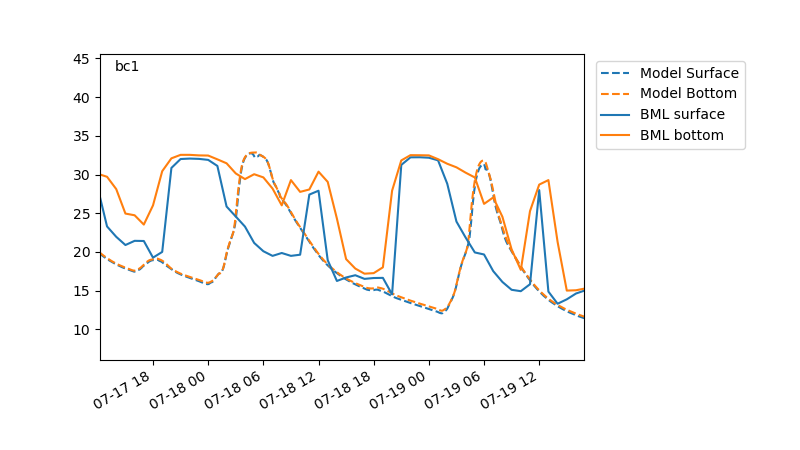

In [205]:
FigSalt(his_ds,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond)

<IPython.core.display.Javascript object>


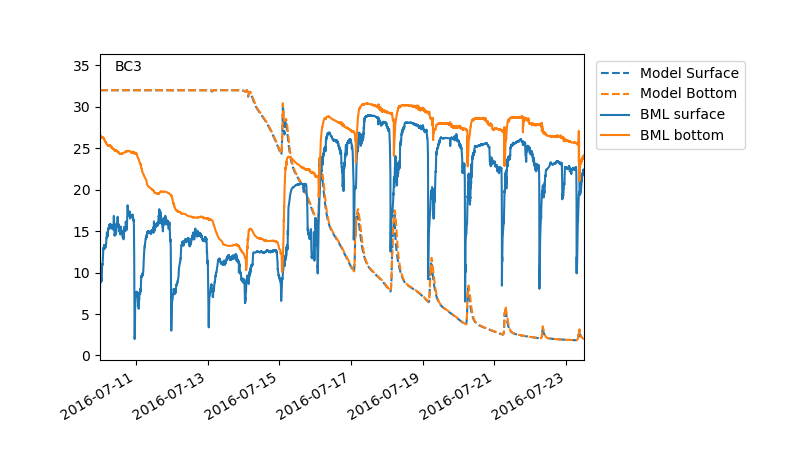

In [206]:
FigSalt(his_ds,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat)

<IPython.core.display.Javascript object>


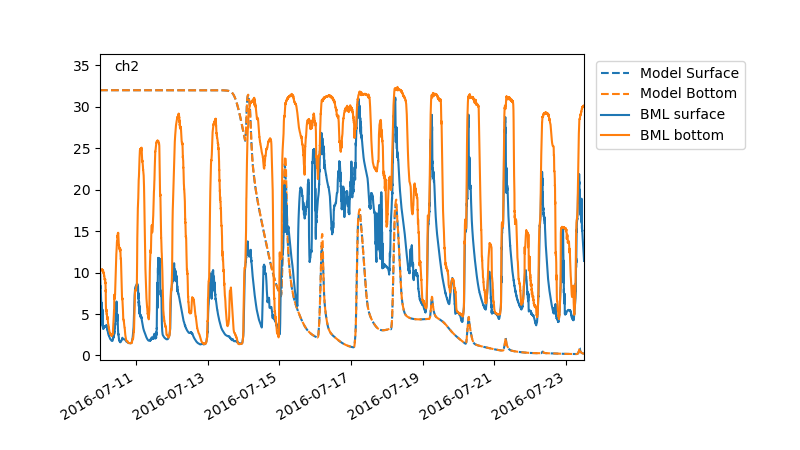

In [207]:
FigSalt(his_ds,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat)

Compare BCs
--

Seem to be fine


In [208]:
bcs=model.load_bcs()
bc_names=[bc['name'] for bc in bcs]
pesca_ck_bc=bcs[bc_names.index('pescadero_ck')]
butano_ck_bc=bcs[bc_names.index('butano_ck')]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [209]:
# USGS gauge: 11162500
from stompy.io.local import usgs_nwis

da=pesca_ck_bc['data']
pesca_usgs=usgs_nwis.nwis_dataset(11162500,start_date=da.time.values[0],
                                  end_date=da.time.values[-1],
                                  products=[60])

INFO:usgs_nwis:Fetching 11162500_60_2016-07-01_2016-08-01.nc


In [210]:
his_ds.close()
his_ds=xr.open_dataset(model.his_output())

In [211]:
his_ds.cross_section_name

<xarray.DataArray 'cross_section_name' (cross_section: 10)>
array([b'mouth_xs', b'n_pond_xs', b'n_ditch_xs', b'n_complex_xs',
       b'pesca_mid_xs', b'butano_lower_xs', b'pesca_lower_xs', b'pesca_bc_xs',
       b'butano_bc_xs', b'butano_mid_xs'], dtype='|S64')
Coordinates:
    cross_section_name  (cross_section) |S64 b'mouth_xs' ... b'butano_mid_xs'
Dimensions without coordinates: cross_section
Attributes:
    cf_role:    timeseries_id
    long_name:  cross section name

<IPython.core.display.Javascript object>


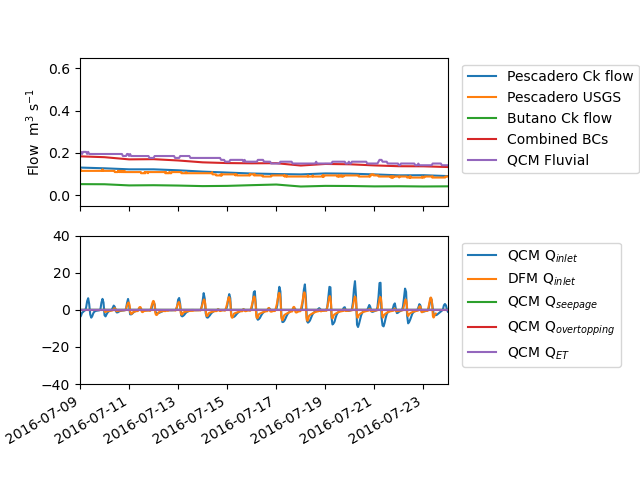

In [212]:
mouth=his_ds.isel(cross_section=0)
fig,(ax,ax_other)=plt.subplots(2,1,sharex=True)

Q=pesca_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Pescadero Ck flow")

ax.plot(pesca_usgs.time,
        pesca_usgs.stream_flow_mean_daily * 0.3048**3,
        label='Pescadero USGS')

Q=butano_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Butano Ck flow")

Q_comb=butano_ck_bc['data'].flow + pesca_ck_bc['data'].flow
ax.plot(Q_comb.time, Q_comb, label="Combined BCs")

ax.plot(qcm.time, qcm['combined fluvial'] * 0.3048**3,label='QCM Fluvial')
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1])

fig.subplots_adjust(right=0.70)

ax.set_ylabel('Flow  m$^3$ s$^{-1}$')
ax.axis(xmin=da.time.values[0],xmax=da.time.values[-1],ymin=-0.05,ymax=0.65)

# And other fluxes:
ax_other.plot(qcm.time, qcm['Modeled inlet flow'] * 0.3048**3,label='QCM Q$_{inlet}$')
ax_other.plot(mouth.time, mouth['cross_section_discharge'],label="DFM Q$_{inlet}$" )

ax_other.plot(qcm.time, qcm['Modeled seepage'] * 0.3048**3,label='QCM Q$_{seepage}$')
ax_other.plot(qcm.time, qcm['Modeled wave overtopping'] * 0.3048**3,label='QCM Q$_{overtopping}$')
ax_other.plot(qcm.time, qcm['Modeled ET'] * 0.3048**3,label='QCM Q$_{ET}$')

ax_other.legend(loc='upper left',bbox_to_anchor=[1.02,1])
ax_other.axis(ymin=-40,ymax=40)



fig.autofmt_xdate()

<IPython.core.display.Javascript object>


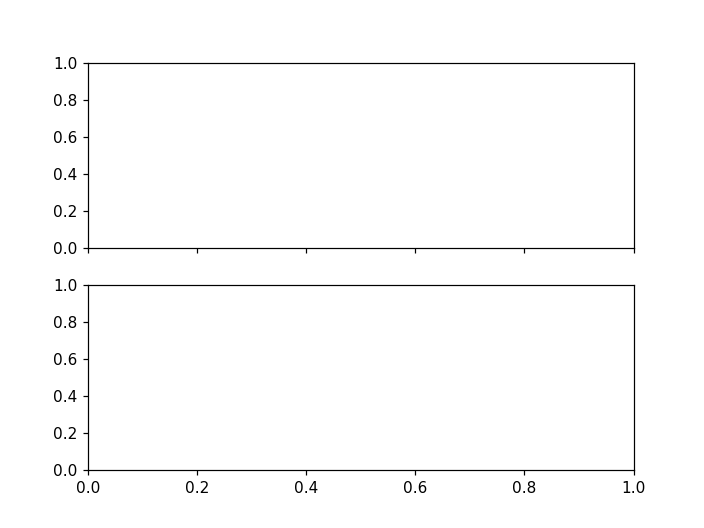

In [33]:
stn_ds=his_ds.isel(stations=7) # nck

fig,axs=plt.subplots(2,1,sharex=True)
for ax,v in zip(axs,['tke','vicww']):
    if v not in stn_ds: continue
    img=ax.imshow(stn_ds[v].values.T.clip(1e-7),aspect="auto",norm=colors.LogNorm(vmin=1e-7,vmax=1e-3),
                  cmap='turbo',origin='lower')
    plt.colorbar(img,ax=ax,label=v)


<IPython.core.display.Javascript object>


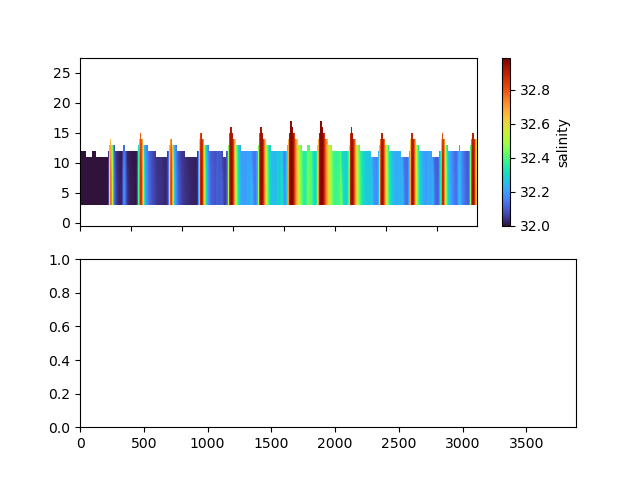

NameError: name 'his55' is not defined

In [190]:
# Salinity:
his_ds.close()

his_ds=xr.open_dataset(model.his_output())
fig,axs=plt.subplots(2,1,sharex=True)

img0=axs[0].imshow(his_ds.isel(stations=7)['salinity'].values.T,
                   aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img0,ax=axs[0],label='salinity')

img1=axs[1].imshow(his55.isel(stations=7)['salinity'].values.T,
                   aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img1,ax=axs[1],label='salinity')

axs[0].axis(xmin=0,xmax=his_ds.time.shape[0])

In [ ]:
# Salinity:
stn_ds=his_ds.isel(stations=7) # nck
fig,ax=plt.subplots(1,1,sharex=True)

img=ax.imshow(stn_ds['salinity'].values.T,
                  aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img,ax=ax,label='salinity')


In [ ]:
# For one of the longer runs, compute some max velocities over time,
# look at history output of velocity
# See if velocity is getting spiky.
his55=xr.open_dataset('run_salt_20160520-v55/DFM_OUTPUT_flowfm/flowfm_0000_his.nc')

In [ ]:
stn55=his55.isel(stations=2)
stn55

In [116]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)

mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v64/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [117]:
# 3-hourly output.  Get 20 output steps to span a few tides
umags=mu['mesh2d_ucmag'].isel(time=slice(100,120)).values

umax=np.nanmax(np.abs(umags),axis=0)

ValueError: zero-size array to reduction operation fmax which has no identity

In [ ]:
umax=np.nanmax(umax,axis=1)

In [ ]:
plt.figure()
ccoll=mu.grid.plot_cells(values=umax,cmap='turbo',clim=[0,1.0])
plt.axis('equal')
plt.axis( (551879., 552837., 4124062., 4124953.) )
plt.colorbar(ccoll)
ccoll.set_edgecolors('face')

In [ ]:
plt.axis()

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True)

img0=axs[0].imshow( stn55.x_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img0,ax=axs[0])
img1=axs[1].imshow( stn55.y_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img1,ax=axs[1])
img2=axs[2].imshow( stn55.z_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img2,ax=axs[2])

img0.set_clim([-0.4,0.4])
img1.set_clim([-0.4,0.4])
img2.set_clim([-0.02,0.02])


<IPython.core.display.Javascript object>


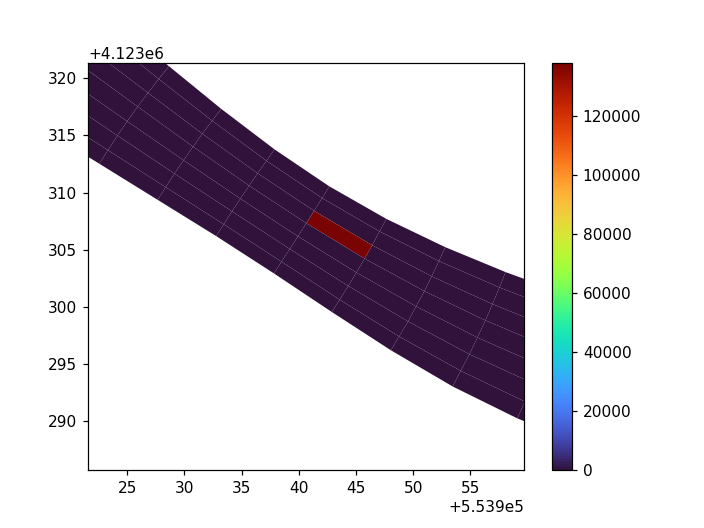

(551856.9727258877, 554172.3087989085, 4122619.5656163436, 4125496.2586278315)

In [118]:
# Drill down on time-step limiting cell up on Pescadero Ck.
plt.figure()
ccoll=mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1),
                         cmap='turbo')
plt.colorbar(ccoll)
plt.axis('equal')

In [126]:
plt.axis()

(553921.5750742665, 553959.7240477271, 4123285.7568246885, 4123321.290747549)

In [119]:
bad_cell=np.argmax(mu['mesh2d_Numlimdt'].isel(time=-1).values)
bad_cell # 10678
# Nowhere near a domain boundary


10678

In [121]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9154, mesh2d_nFaces: 5705, mesh2d_nInterfaces: 29, mesh2d_nLayers: 28, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3450, time: 12)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.53e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.531e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-06-01 ... 2016-06...
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 1.659 1.635 ... 2.219
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 1 2 3 ... 3440 3439
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 1.0 2.0 ... 0.0
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
    mesh2d_interface_z           (mesh2d_nInterfaces) float64 ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 1.0 1.0 1.0 ... 3.0 3.0
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 21.54 22.08 ... 22.51
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 1.659 1.275 ... 2.214
    mesh2d_flowelem_domain       (mesh2d_nFaces) float64 5.0 5.0 5.0 ... 7.0 7.0
    mesh2d_flowelem_globalnr     (mesh2d_nFaces) float64 6.251e+04 ... 5.284e+04
    timestep                     (time) float64 ...
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 ...
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_u1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_u0                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_ucx                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucy                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucz                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucxa                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucya                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucmaga                (time, mesh2d_nFaces) float64 ...
    mesh2d_ww1                   (time, mesh2d_nFaces, mesh2d_nInterfaces) float64 ...
    mesh2d_rho                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_q1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_viu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_diu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 ...
    mesh2d_sa1                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_tem1                  (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_turkin1               (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_vicwwu                (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_tureps1               (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
Attributes:
    institution:    Deltares
    references:     h

In [125]:
for v in ['mesh2d_Numlimdt','mesh2d_waterdepth','mesh2d_ucmag']:
    print(v,mu[v].isel(time=-1,mesh2d_nFaces=bad_cell).values)
    
# Velocity is 1 m/s, in 0.10m of water.


mesh2d_Numlimdt 138031.0
mesh2d_waterdepth 0.10600182513406509
mesh2d_ucmag [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 1.03991764 1.11949989        nan        nan
        nan        nan        nan        nan]


<IPython.core.display.Javascript object>


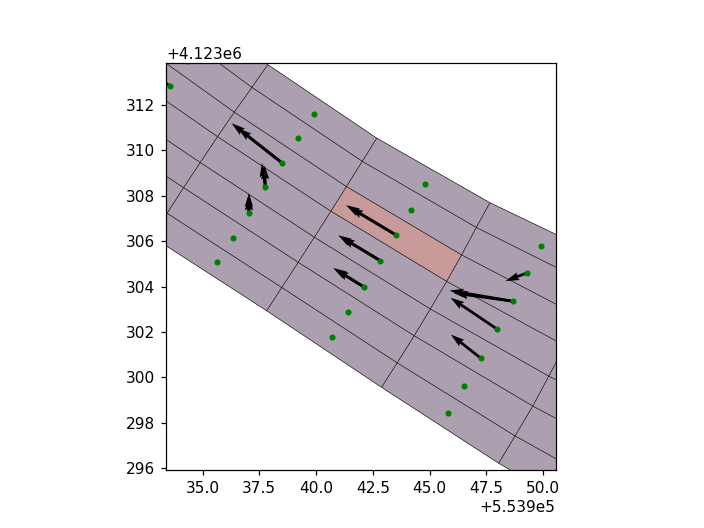

(553921.5750742665, 553959.7240477271, 4123285.7568246885, 4123321.290747549)

In [139]:
zoom=(553921.5750742665, 553959.7240477271, 4123285.7568246885, 4123321.290747549)

plt.figure()

mu.grid.plot_edges(color='k',lw=0.4)

csel=np.nonzero(mu.grid.cell_clip_mask(zoom))[0]

mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1),
                   clip=zoom,cmap='turbo',alpha=0.4)

cc=mu.grid.cells_center()[csel]
plt.plot(cc[:,0],cc[:,1],'g.')

#ucx,ucy


ucx=mu['mesh2d_ucx'].isel(time=-1,mesh2d_nFaces=csel)
ucy=mu['mesh2d_ucy'].isel(time=-1,mesh2d_nFaces=csel)

u,v,x,y = xr.broadcast(ucx, ucy, ucx.mesh2d_face_x, ucx.mesh2d_face_y)

valid=np.isfinite(u)

u=u.values[valid]
v=v.values[valid]
x=x.values[valid]
y=y.values[valid]

plt.quiver(x,y,u,v)

plt.axis(zoom)


In [142]:
proc,local=mu.cell_g2l[bad_cell]
ds=mu.dss[proc]
gloc=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [145]:
gloc.nodes

array([([ 554060.88838938, 4123255.08432303], False, 0.        ),
       ([ 554066.06164366, 4123251.98029609], False, 0.        ),
       ([ 554059.860724  , 4123253.38340529], False, 0.        ), ...,
       ([ 553285.14824419, 4123465.02120687], False, 3.225     ),
       ([ 553165.22729127, 4123376.34640524], False, 2.70305603),
       ([ 553160.8742972 , 4123372.6612673 ], False, 2.53588859)],
      dtype=[('x', '<f8', (2,)), ('deleted', '?'), ('mesh2d_node_z', '<f8')])

In [152]:
gloc.cells.dtype

dtype([('edges', '<i4', (4,)), ('nodes', '<i4', (4,)), ('_center', '<f8', (2,)), ('mark', '<i4'), ('_area', '<f8'), ('deleted', '?'), ('mesh2d_face_x_bnd', '<f8', (4,)), ('mesh2d_face_y_bnd', '<f8', (4,)), ('mesh2d_flowelem_ba', '<f8'), ('mesh2d_flowelem_bl', '<f8'), ('mesh2d_flowelem_domain', '<f8'), ('mesh2d_flowelem_globalnr', '<f8')])

In [155]:
mu.grid.cells.dtype

dtype([('edges', '<i4', (4,)), ('nodes', '<i4', (4,)), ('_center', '<f8', (2,)), ('mark', '<i4'), ('_area', '<f8'), ('deleted', '?'), ('mesh2d_face_x_bnd', '<f8', (4,)), ('mesh2d_face_y_bnd', '<f8', (4,)), ('mesh2d_flowelem_ba', '<f8'), ('mesh2d_flowelem_bl', '<f8'), ('mesh2d_flowelem_domain', '<f8'), ('mesh2d_flowelem_globalnr', '<f8'), ('ghostness', '<i4'), ('proc', '<i4')])

<IPython.core.display.Javascript object>


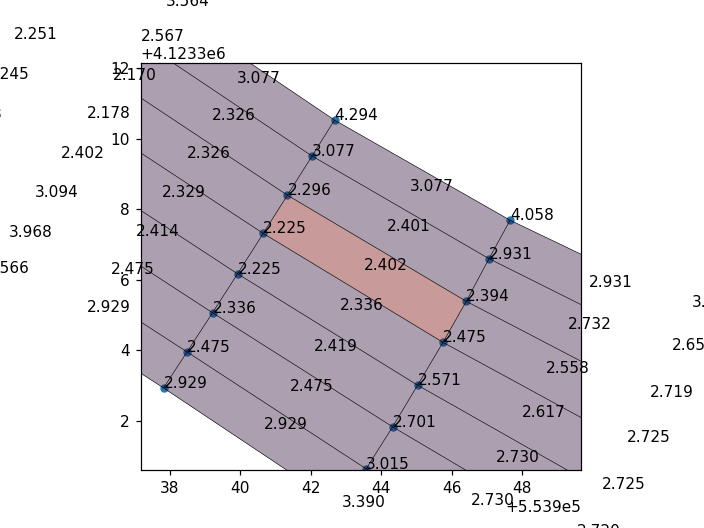

(553921.5750742665, 553959.7240477271, 4123285.7568246885, 4123321.290747549)

In [160]:
plt.figure()
gloc.plot_edges(color='k',lw=0.4)

gloc.plot_nodes(labeler=lambda i,r: "%.3f"%(gloc.nodes['mesh2d_node_z'][i]),
                clip=zoom)

#mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1),
#                   clip=zoom,cmap='turbo',alpha=0.4,
#                   labeler=lambda i,r: "%.3f"%(mu.grid.cells['mesh2d_flowelem_bl'][i]))
mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1),
                   clip=zoom,cmap='turbo',alpha=0.4,
                   labeler=lambda i,r: "%.3f"%(mu['mesh2d_s1'].isel(time=-1).values[i]))

plt.axis(zoom)

In [ ]:
# layer interfaces:
# 2.0, 2.125, 2.25, 2.375.
# So the surface layer is a bit thin, 2.5cm.
# Problem is probably the vertical fall.
# The next cell downstream has s1 at 2.32, so an 8cm
# fall over a few meters, and the thin surface layer
# has no outlet downstream, so probably having to empty
# through the downstairs cell?
# vertical velocity is 1.35 cm/s, and with a CFL limit
# 0.7, that's a 1.40s timestep.  Might be jumping a bit
# so entirely possible.
# Best solution is probably run this section in 2D, and maybe
# increase friction up here if that's physically reasonable.




In [167]:
(2.402-2.375)/0.0135 * 0.7

1.400000000000007

In [164]:

ds['mesh2d_ww1'].isel(time=-1,mesh2d_nFaces=local)

<xarray.DataArray 'mesh2d_ww1' (mesh2d_nInterfaces: 29)>
array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
        0.000000e+00, -1.355566e-02, -3.614407e-08,           nan,
                 nan,           nan,           nan,           nan,
                 nan])
Coordinates:
    mesh2d_face_x  float64 5.539e+05
    mesh2d_face_y  float64 4.123e+06
    time           datetime64[ns] 2016-06-03T18:00:00
Dimensions without coordinates: mesh2d_nInterfaces
Attributes:
    mesh:           mesh2d
    location:       face
    cell_methods:   mesh2d_nFaces: mean
    cell_measures:  area: mesh2d_flowelem_ba
    standard_name:  upward_sea_water_velocity
    long_name:      Upward velocity on vertical interface, n-component
    units:          m s-1
    grid_mapping:   projected_coordinate_system

In [158]:
# Problem cell has node elevations 
# 2.225, 2.296, 2.394 and 2.475.
# z interfaces are every 0.125.
# Cell bl is 2.296, and free surface at 2.402246.
# (thus 0.1m depth).

mu['mesh2d_s1'].isel(time=-1,mesh2d_nFaces=bad_cell)

<xarray.DataArray 'mesh2d_s1' ()>
array(2.402246)
Coordinates:
    mesh2d_face_x  float64 5.539e+05
    mesh2d_face_y  float64 4.123e+06
    time           datetime64[ns] 2016-06-03T18:00:00
Attributes:
    mesh:           mesh2d
    location:       face
    cell_methods:   mesh2d_nFaces: mean
    cell_measures:  area: mesh2d_flowelem_ba
    standard_name:  sea_surface_height
    long_name:      Water level
    units:          m
    grid_mapping:   projected_coordinate_system

In [266]:
# Effect of keepzlayeringatbed:
# stairstepped
versions=["v66","v69","v70"]

his_fns=[f"run_salt_20160520-{ver}/DFM_OUTPUT_flowfm/flowfm_0000_his.nc"
         for ver in versions]
try:
    [ds.close() for ds in hiss]
except NameError:
    pass

hiss=[xr.open_dataset(fn) for fn in his_fns]

ncks=[ his.isel(stations=7) for his in hiss]

<IPython.core.display.Javascript object>


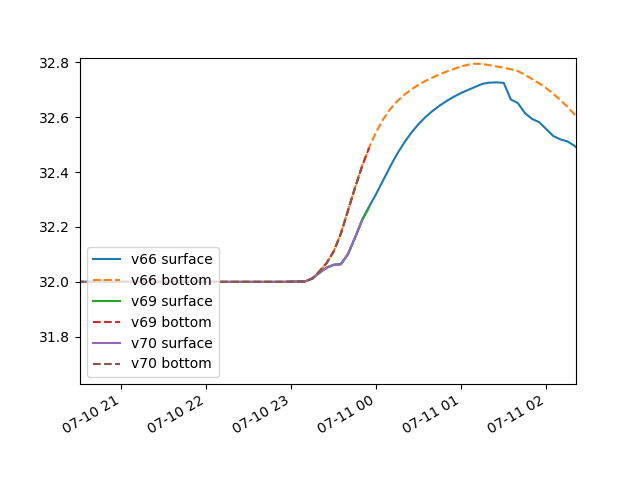

In [267]:
fig=plt.figure()
for ver,nck in zip(versions,ncks):
    plt.plot(nck.time, surface(nck['salinity']), label=ver+' surface')
    plt.plot(nck.time, bottom(nck['salinity']), label=ver+' bottom',ls='--')
#plt.plot(nck66.time, surface(nck66['salinity']), label='66-surface')
#plt.plot(nck66.time, bottom(nck66['salinity']), label='66-bottom')
plt.legend(loc='lower left')
fig.autofmt_xdate()